In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
#from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from data_loading import DataPreprocessor
from random_forest_classifier_2a import plot_predicted_vs_actual,plot_rf_predictions
from random_forest_classifier_2a import split_train_val_per_id


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/madalenabarcelo/Desktop/BA/DMT/DataMiningTechniquesA1/notebooks/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.lau

In [3]:
data_loader = DataPreprocessor()
train_df, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False, for_RNN_model=False)

Removed 53 outliers from 1268 observations. Percentage: 4.18%


In [4]:
test_predictions = []
train_predictions = []
test_actuals = []
train_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    
    train_user_df, test_user_df = split_train_val_per_id(train_group, val_frac=0.2)

    X_train = train_user_df.drop(columns=["id", "mood", "date"])
    y_train = train_user_df["mood"]
    X_test = test_user_df.drop(columns=["id", "mood", "date"])
    y_test = test_user_df["mood"]


    model = RandomForestRegressor(
        max_depth=3,            # limits how deep each tree can go
        min_samples_split=10,   # minimum samples to allow a split
        min_samples_leaf=4,     # minimum samples in a leaf
        max_leaf_nodes=None,      # max number of leaf nodes
        n_estimators=100,       # number of trees in the forest
        random_state=42
    )
    
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    train_predictions.extend(train_preds)
    train_actuals.extend(y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)


Training Data - MAPE: 4.35%, MAE: 0.29, MSE: 0.17, R_squared: 0.69
Test Data - MAPE: 7.85%, MAE: 0.53, MSE: 0.51, R_squared: 0.13


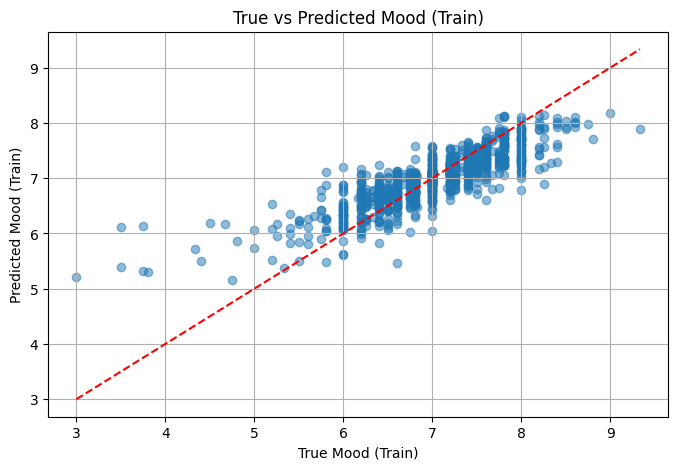

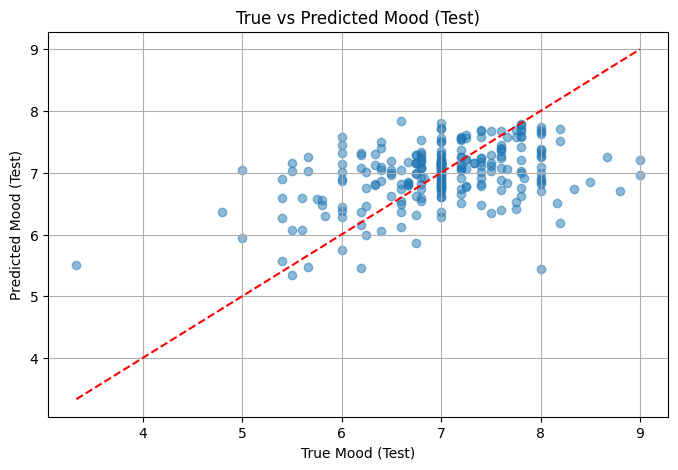

In [7]:
plot_rf_predictions(train_actuals, train_predictions, test_actuals, test_predictions)

In [6]:
# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)

    user_id  predicted_next_day_mood
0   AS14.01                 7.276676
1   AS14.02                 7.122573
2   AS14.03                 7.570943
3   AS14.05                 6.922236
4   AS14.06                 7.063406
5   AS14.07                 5.389339
6   AS14.08                 6.683235
7   AS14.09                 6.333516
8   AS14.12                 6.358049
9   AS14.13                 6.917361
10  AS14.14                 6.915020
11  AS14.15                 7.077707
12  AS14.16                 6.849432
13  AS14.17                 7.063367
14  AS14.19                 6.696275
15  AS14.20                 6.972678
16  AS14.23                 7.109789
17  AS14.24                 6.794937
18  AS14.25                 7.142830
19  AS14.26                 7.311983
20  AS14.27                 7.447137
21  AS14.28                 7.099538
22  AS14.29                 7.431567
23  AS14.30                 7.573596
24  AS14.31                 7.153913
25  AS14.32                 7.373723
2

In [ ]:
# Grid search for parameters

# Getting best parameter values for pruning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 50],
    'n_estimators': [100],  # keep this fixed for now, or add [50, 100, 200] if you want
}

# Create your regressor
rf = RandomForestRegressor(random_state=42)

# Define scoring: R² is common for regression
scorer = make_scorer(r2_score)

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # use all cores
    verbose=1
)

# Fit to your full training set (X and y must be the full training data for all users combined)
X = train_df.drop(columns=['id', 'mood', 'date'])
y = train_df['mood']
grid_search.fit(X, y)
a
# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated R²:", grid_search.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found: {'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated R²: -0.11415708743930415


Training Data - MAPE: 4.77%, MAE: 0.31, MSE: 0.21, R_squared: 0.61
Test Data - MAPE: 7.45%, MAE: 0.50, MSE: 0.47, R_squared: 0.20


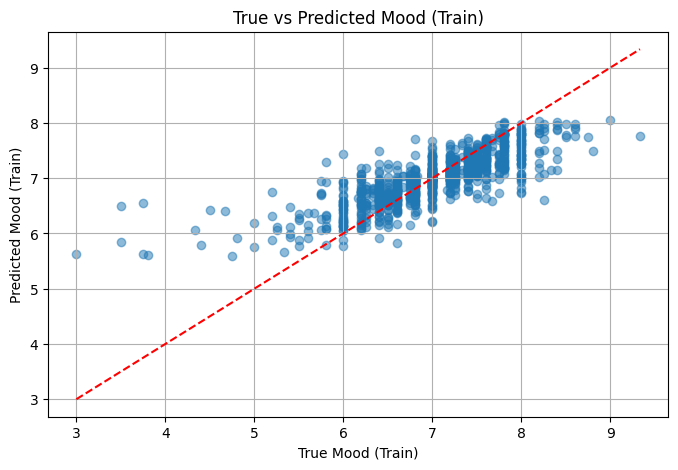

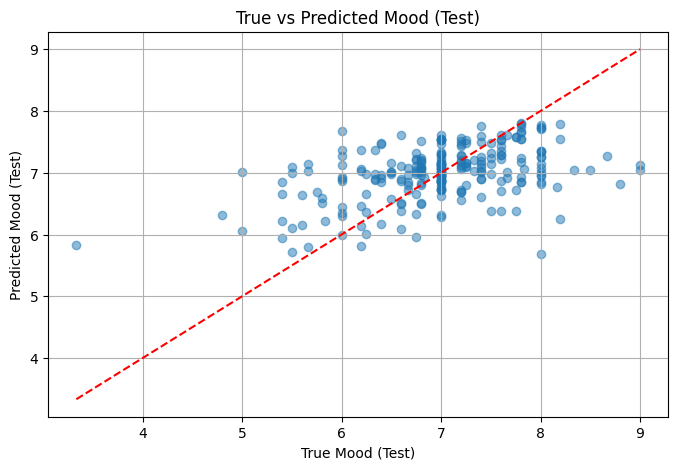

    user_id  predicted_next_day_mood
0   AS14.01                 7.312167
1   AS14.02                 7.088583
2   AS14.03                 7.623833
3   AS14.05                 6.800333
4   AS14.06                 7.043000
5   AS14.07                 5.675500
6   AS14.08                 6.898500
7   AS14.09                 6.356250
8   AS14.12                 6.389250
9   AS14.13                 7.147500
10  AS14.14                 6.829083
11  AS14.15                 7.070000
12  AS14.16                 6.868750
13  AS14.17                 7.088750
14  AS14.19                 6.626500
15  AS14.20                 7.050750
16  AS14.23                 7.244750
17  AS14.24                 6.873167
18  AS14.25                 7.036500
19  AS14.26                 7.276250
20  AS14.27                 7.469667
21  AS14.28                 7.146750
22  AS14.29                 7.609417
23  AS14.30                 7.653833
24  AS14.31                 7.039750
25  AS14.32                 7.355083
2

In [15]:
# 5 absolute error

test_predictions = []
train_predictions = []
test_actuals = []
train_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    
    train_user_df, test_user_df = split_train_val_per_id(train_group, val_frac=0.2)

    X_train = train_user_df.drop(columns=["id", "mood", "date"])
    y_train = train_user_df["mood"]
    X_test = test_user_df.drop(columns=["id", "mood", "date"])
    y_test = test_user_df["mood"]


    model = RandomForestRegressor(criterion='absolute_error',
        max_depth=3,            # limits how deep each tree can go
        min_samples_split=10,   # minimum samples to allow a split
        min_samples_leaf=4,     # minimum samples in a leaf
        max_leaf_nodes=None,      # max number of leaf nodes
        n_estimators=100,       # number of trees in the forest
        random_state=42
    )
    
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    train_predictions.extend(train_preds)
    train_actuals.extend(y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)

plot_rf_predictions(train_actuals, train_predictions, test_actuals, test_predictions)

# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)


Training Data - MAPE: 4.35%, MAE: 0.29, MSE: 0.17, R_squared: 0.69
Test Data - MAPE: 7.85%, MAE: 0.53, MSE: 0.51, R_squared: 0.13


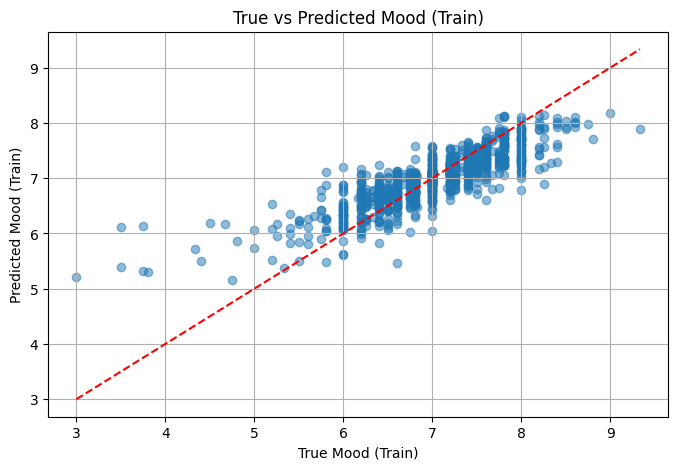

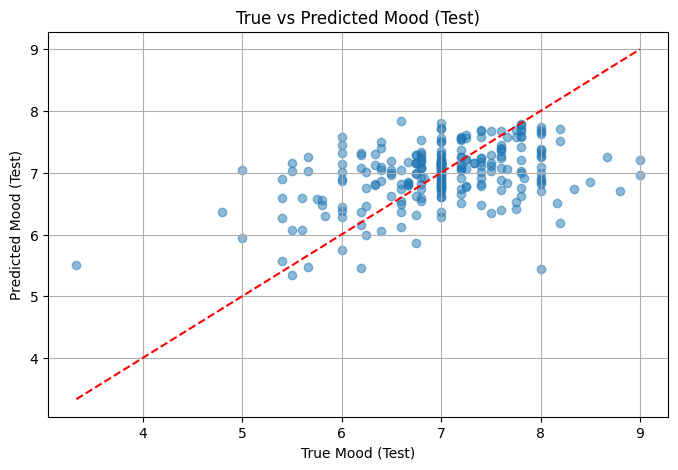

    user_id  predicted_next_day_mood
0   AS14.01                 7.276676
1   AS14.02                 7.122573
2   AS14.03                 7.570943
3   AS14.05                 6.922236
4   AS14.06                 7.063406
5   AS14.07                 5.389339
6   AS14.08                 6.683235
7   AS14.09                 6.333516
8   AS14.12                 6.358049
9   AS14.13                 6.917361
10  AS14.14                 6.915020
11  AS14.15                 7.077707
12  AS14.16                 6.849432
13  AS14.17                 7.063367
14  AS14.19                 6.696275
15  AS14.20                 6.972678
16  AS14.23                 7.109789
17  AS14.24                 6.794937
18  AS14.25                 7.142830
19  AS14.26                 7.311983
20  AS14.27                 7.447137
21  AS14.28                 7.099538
22  AS14.29                 7.431567
23  AS14.30                 7.573596
24  AS14.31                 7.153913
25  AS14.32                 7.373723
2

In [16]:
# 5 squared error

test_predictions = []
train_predictions = []
test_actuals = []
train_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    
    train_user_df, test_user_df = split_train_val_per_id(train_group, val_frac=0.2)

    X_train = train_user_df.drop(columns=["id", "mood", "date"])
    y_train = train_user_df["mood"]
    X_test = test_user_df.drop(columns=["id", "mood", "date"])
    y_test = test_user_df["mood"]


    model = RandomForestRegressor(criterion='squared_error',
        max_depth=3,            # limits how deep each tree can go
        min_samples_split=10,   # minimum samples to allow a split
        min_samples_leaf=4,     # minimum samples in a leaf
        max_leaf_nodes=None,      # max number of leaf nodes
        n_estimators=100,       # number of trees in the forest
        random_state=42
    )
    
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    train_predictions.extend(train_preds)
    train_actuals.extend(y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)

plot_rf_predictions(train_actuals, train_predictions, test_actuals, test_predictions)

# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)
